# Analysis of Netflix Data with IMDB Ratings

## Data Creation and Cleaning

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import os
import opendatasets as od
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display # For widgets
from wordcloud import WordCloud # For wordcloud visualization

%matplotlib inline


# The following modules will assist in acquiring the IMDb data
from io import StringIO # For creation of string inputs to be read as '.tsv' by pandas
import re # For separation of netflix_df.country strings into lists
import gzip # For extraction of IMDB datasets
import urllib.request

### Let's first download the Netflix dataset from Kaggle using the opendatasets library.

In [6]:
data_url = "https://www.kaggle.com/shivamb/netflix-shows"
od.download(data_url)

100%|██████████| 1.18M/1.18M [00:00<00:00, 78.7MB/s]

In [7]:
ndf = pd.read_csv('netflix-shows/netflix_titles.csv', index_col='show_id', low_memory=False)

In [8]:
ndf.head(5)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [9]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7787 entries, s1 to s7787
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   type          7787 non-null   object
 1   title         7787 non-null   object
 2   director      5398 non-null   object
 3   cast          7069 non-null   object
 4   country       7280 non-null   object
 5   date_added    7777 non-null   object
 6   release_year  7787 non-null   int64 
 7   rating        7780 non-null   object
 8   duration      7787 non-null   object
 9   listed_in     7787 non-null   object
 10  description   7787 non-null   object
dtypes: int64(1), object(10)
memory usage: 730.0+ KB


### The Netflix download does not include any information on viewers' ratings; the 'rating' column in the above info refers to MPAA rating.  We can get users' rating info from IMDB.  They make their data available at https://datasets.imdbws.com.

In [10]:
# Download IMDB files from official repository
urllib.request.urlretrieve('https://datasets.imdbws.com/title.ratings.tsv.gz', 'title.ratings.tsv.gz');
urllib.request.urlretrieve('https://datasets.imdbws.com/title.basics.tsv.gz', 'title.basics.tsv.gz');

#extract files as text
with gzip.open('title.ratings.tsv.gz', 'rt', encoding='utf8') as reader:
    ratings_contents = reader.read()

with gzip.open('title.basics.tsv.gz', 'rt', encoding='utf8') as reader:
    basics_contents = reader.read()
    
# Create text strings to be loaded into panda.read_csv as a tab separated file
ratings_data = StringIO(ratings_contents)
basics_data = StringIO(basics_contents)

# Create pandas dataframe from tab separated file for ratings
imdb_ratings_df_raw = pd.read_csv(ratings_data, sep='\t', low_memory=False)

# Create pandas dataframe from tab separated file for titles
imdb_titles_df_raw = pd.read_csv(basics_data, sep='\t', low_memory=False)

# We will make a copy of our raw data, dropping any duplicate rows in the process
imdb_ratings_df = imdb_ratings_df_raw.copy().drop_duplicates()
imdb_titles_df = imdb_titles_df_raw.copy().drop_duplicates()

### Since the IMDB database is so vast, it comes in multiple files.  I only grabbed the two that I need to make a connection to the Netflix data: 'title.ratings.tsv' and 'title.basics.tsv'.  Let's have a look at the two IMDb dataframes separately and make sure the data is valid.

In [11]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
787855,tt3120346,7.6,5
232583,tt0433393,7.6,21
400319,tt0854830,6.3,15
127628,tt0196664,1.5,37
509800,tt11611100,7.1,24


In [12]:
imdb_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1113583 entries, 0 to 1113582
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1113583 non-null  object 
 1   averageRating  1113583 non-null  float64
 2   numVotes       1113583 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 34.0+ MB


### The Dtypes of 'imdb_ratings_df' look correct and there appear to be no null entries.  Let's check 'imdb_titles_df'.

In [13]:
imdb_titles_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
2247615,tt12240588,short,The Perfect Candidate,The Perfect Candidate,0,2020,\N,5,"Romance,Short"
6112003,tt6897118,tvEpisode,Episode #1.66,Episode #1.66,0,2003,\N,\N,"Drama,Mystery,Romance"
4716129,tt3780612,short,Carte postale,Carte postale,0,2013,\N,\N,"Drama,Short"
6270074,tt7235328,tvEpisode,Episode #10.14,Episode #10.14,0,2005,\N,\N,Reality-TV
4968051,tt4343672,tvEpisode,"Real Fears, Real Solutions","Real Fears, Real Solutions",0,2006,\N,\N,Talk-Show


In [14]:
imdb_titles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7531576 entries, 0 to 7531575
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 574.6+ MB


### All of the columns are of dtype 'object' and we do not get a null count.  This might present problems later in our analysis, but we will cross that bridge when we come to it.
### Let's combine our two IMDb dataframes into a single dataframe, matching titles with their user ratings.  We will accomplish this by joining them on their 'tconst' column and making this the index of the resulting dataframe.

In [15]:
idf = pd.merge(imdb_titles_df.set_index('tconst'), imdb_ratings_df.set_index('tconst'), left_index=True, right_index=True, how='inner').drop_duplicates()
idf.sample(5)

,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
tconst,,,,,,,,,,
tt4481416,tvEpisode,Model Behavior,Model Behavior,0,2015,\N,42,"Drama,Family,Romance",8.4,42
tt0521864,tvEpisode,"Go Bernie, It's Your Birthday","Go Bernie, It's Your Birthday",0,2004,\N,21,"Comedy,Drama,Family",7.1,18
tt1638308,movie,A Fish Story,A Fish Story,0,2013,\N,110,Family,6.1,148
tt9230220,tvEpisode,Seven and a Half Minutes,Seven and a Half Minutes,0,2018,\N,42,"Crime,Documentary",7.8,11
tt1572158,movie,Malta Radio,Malta Radio,0,2009,\N,84,Documentary,8.1,8


In [16]:
idf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1113485 entries, tt0000001 to tt9916778
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   titleType       1113485 non-null  object 
 1   primaryTitle    1113485 non-null  object 
 2   originalTitle   1113485 non-null  object 
 3   isAdult         1113485 non-null  object 
 4   startYear       1113485 non-null  object 
 5   endYear         1113485 non-null  object 
 6   runtimeMinutes  1113485 non-null  object 
 7   genres          1113483 non-null  object 
 8   averageRating   1113485 non-null  float64
 9   numVotes        1113485 non-null  int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 93.4+ MB


### There are a couple of different ways we can choose to join the IMDb and Netflix dataframes so that the data lines up correctly.  I have chosen to combine them where idf['primaryTitle', 'startYear'] and ndf['title', 'release_year'] match; this will minimize mismatched rows.
### Recall (and you can see just above) that idf[startYear] is of Dtype 'object'; we need to drop any non-numeric values and convert the column to 'int64' in order to compare the values with those of the Netflix dataframe.

In [17]:
idf = idf[idf.startYear.apply(lambda x: str(x).isnumeric())]
idf['startYear'] = idf['startYear'].astype(int)

### Let's convert all titles to lowercase to avoid misses and join the two dataframes

In [18]:
ndf['title'] = ndf['title'].str.lower()
idf['primaryTitle'] = idf['primaryTitle'].str.lower()

In [19]:
df = pd.merge(ndf, idf, left_on=['title', 'release_year'], right_on=['primaryTitle', 'startYear'], how='inner').drop_duplicates().reset_index()
df = df.drop('index', axis=1)
df.sample(5)

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
1455,Movie,don't go breaking my heart,Johnnie To,"Louis Koo, Gao Yuanyuan, Daniel Wu",Hong Kong,"December 1, 2018",2011,TV-PG,115 min,"Comedies, International Movies, Romantic Movies",A financial analyst succumbs to a love triangl...,movie,don't go breaking my heart,Daan san nam nui,0,2011,\N,115,Romance,6.5,1530
5788,Movie,tree man,"Jon Reiner, Brad Rothschild",NaN,Canada,"November 1, 2016",2015,TV-PG,82 min,Documentaries,Entrepreneurs from Vermont and Quebec sell Chr...,movie,tree man,Tree Man,0,2015,\N,82,"Documentary,Drama,Family",6.7,81
1758,Movie,for the love of spock,Adam Nimoy,"Leonard Nimoy, William Shatner, George Takei, ...","Canada, United States","December 2, 2016",2016,TV-14,112 min,Documentaries,The son of actor Leonard Nimoy directs this mo...,movie,for the love of spock,For the Love of Spock,0,2016,\N,111,"Biography,Documentary",7.6,3878
4851,Movie,the bridge,Kunle Afolayan,"Chidinma Ekile, Ademola Adedoyin, Kunle Afolay...",Nigeria,"September 1, 2019",2017,TV-14,119 min,"Dramas, International Movies, Romantic Movies",A Yoruba prince and a young lady from a promin...,tvEpisode,the bridge,The Bridge,0,2017,\N,50,"Drama,Sci-Fi,Thriller",8.7,3583
3448,Movie,national bird,Sonia Kennebeck,NaN,United States,"May 8, 2017",2016,TV-MA,92 min,Documentaries,Three former military operatives offer disturb...,movie,national bird,National Bird,0,2016,\N,92,Documentary,7.1,627


### We should parse the categorical 'date_added' column and make a numerical column from each of its constituent parts.  Let's get rid of any Null values.


In [20]:
type(df['date_added'].iloc[0])

str

In [21]:
df = df[df.date_added.isna() == False].reset_index()
df = df.drop("index", axis=1)

In [22]:
#Changing 'date_added' columnn to datetime dtype and creating columnn for each part
df.date_added = pd.to_datetime(df.date_added)
df['year_added'] = pd.DatetimeIndex(df.date_added).year.astype(int)
df['month_added'] = pd.DatetimeIndex(df.date_added).month.astype(int)
df['day_added'] = pd.DatetimeIndex(df.date_added).day.astype(int)

### Next, getting a count of the number of countries involved in a title's release will help our analysis down the line.

In [23]:
# Add a numeric column for the number of countries each title was released to
myList = []
for i in range(df.country.size):
    myList.append(str(df.country[i]).strip().split(','))

In [24]:
# Make a pandas Series from 'country' list
country = pd.Series(myList)

# Create 'country_count' column using map and lambda function involving 'country' Series
df['country_count'] = country.map(lambda x: len(x))

### Let's check the info

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6221 entries, 0 to 6220
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   type            6221 non-null   object        
 1   title           6221 non-null   object        
 2   director        4802 non-null   object        
 3   cast            5687 non-null   object        
 4   country         6041 non-null   object        
 5   date_added      6221 non-null   datetime64[ns]
 6   release_year    6221 non-null   int64         
 7   rating          6215 non-null   object        
 8   duration        6221 non-null   object        
 9   listed_in       6221 non-null   object        
 10  description     6221 non-null   object        
 11  titleType       6221 non-null   object        
 12  primaryTitle    6221 non-null   object        
 13  originalTitle   6221 non-null   object        
 14  isAdult         6221 non-null   object        
 15  star

### The Null values are all in categorical columns.  Let's change them to the string "Unknown".

In [26]:
df = df.fillna("Unknown")

# Exploratory Analysis and Visualization

In [27]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '00000000'

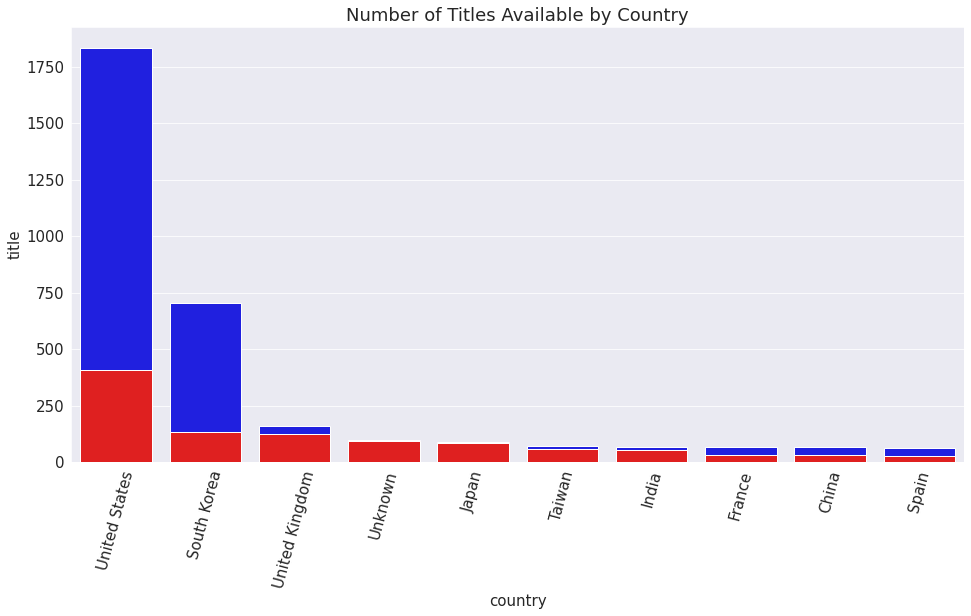

In [28]:
xplt = df[df["type"] == "Movie"].groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt = df[df["type"] == "Movie"].groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)

xplt2 = df[df["type"] == "TV Show"].groupby('country').count().sort_values('title', ascending=False).reset_index().country.head(10)
yplt2 = df[df["type"] == "TV Show"].groupby('country').count().sort_values('title', ascending=False).reset_index().title.head(10)

plt.figure(figsize=(16, 8))
plt.fontsize = 20
plt.xticks(rotation=75)
plt.title(label='Number of Titles Available by Country')
plt.xlabel("Country")
plt.ylabel("Number of Titles")
sns.barplot(x=xplt, y=yplt, color="Blue");
sns.barplot(x=xplt2, y=yplt2, color="Red");

## We can plot how ratings have changed over time

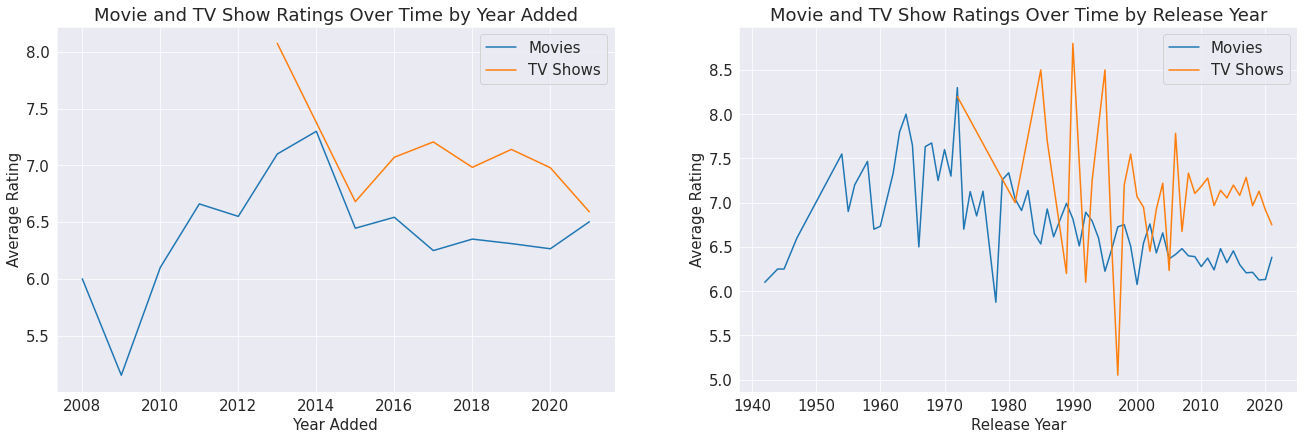

In [29]:
# Group by year added
movie_ratings = df[df.type == 'Movie'].groupby('year_added')['averageRating'].mean()
tv_ratings = df[df.type == 'TV Show'].groupby('year_added')['averageRating'].mean()

movie_ratings2 = df[df.type == 'Movie'].groupby('release_year')['averageRating'].mean()
tv_ratings2 = df[df.type == 'TV Show'].groupby('release_year')['averageRating'].mean()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(x=movie_ratings.index, y=movie_ratings, ax=axes[0]);
sns.lineplot(x=tv_ratings.index, y=tv_ratings, ax=axes[0]);
axes[0].set_title('Movie and TV Show Ratings Over Time by Year Added')
axes[0].set_xlabel("Year Added")
axes[0].set_ylabel("Average Rating")
axes[0].legend(labels=['Movies', 'TV Shows']);


sns.lineplot(x=movie_ratings2.index, y=movie_ratings2, ax=axes[1]);
sns.lineplot(x=tv_ratings2.index, y=tv_ratings2, ax=axes[1]);
axes[1].set_title('Movie and TV Show Ratings Over Time by Release Year')
axes[1].set_xlabel("Release Year")
axes[1].set_ylabel("Average Rating")
axes[1].legend(labels=['Movies', 'TV Shows']);

plt.tight_layout(pad = 5);

### TV shows appear to be performing much more strongly than movies in recent years.  Let's see if this observation holds across regions.  We can use IpyWidgets to make choosing a region easier.

Dropdown(description='Countries', index=57, options=('Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgi…

Button(description='Plot', style=ButtonStyle())

Output()

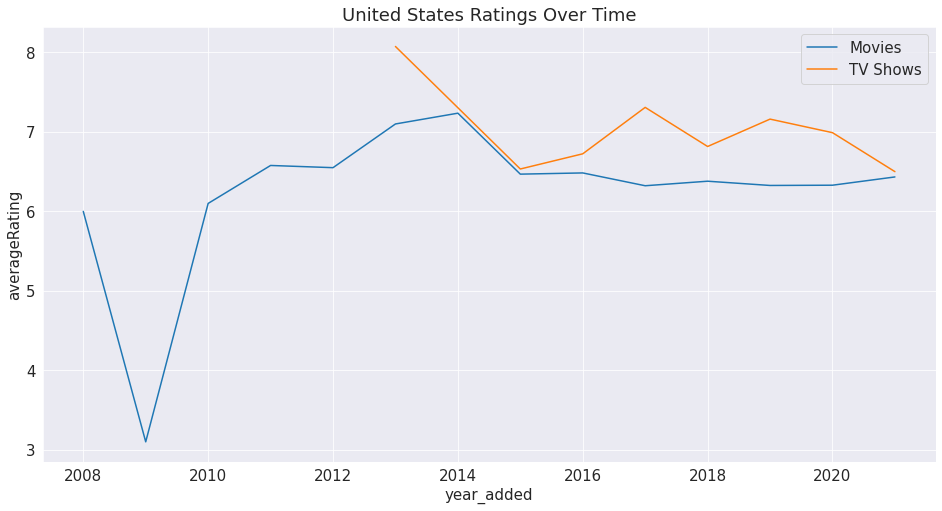

In [30]:
country_list = df[(df.country.isna() == False) & (df.country_count == 1)].country.sort_values().unique().tolist()

country_select = widgets.Dropdown(
                    options = country_list,
                    value = 'United States',
                    description = 'Countries',
                    disabled = False)

display(country_select)

button = widgets.Button(description="Plot")
output = widgets.Output()

matplotlib.rcParams["font.size"] = 15

display(button, output)

def on_button_clicked(b):
    avg_ratings_df = pd.DataFrame()
    country = country_select.value
    tv_avg = df[(df.country.str.contains(country)) & (df.type == 'TV Show')].groupby('year_added').averageRating.mean()
    movie_avg = df[(df.country.str.contains(country)) & (df.type == 'Movie')].groupby('year_added').averageRating.mean()
    with output:
        plt.figure(figsize=(16, 8));
        sns.lineplot(x=movie_avg.index, y=movie_avg);
        sns.lineplot(x=tv_avg.index, y=tv_avg);
        plt.title(label=country + ' Ratings Over Time')
        plt.legend(labels=['Movies', 'TV Shows']);

button.on_click(on_button_clicked)

### Has this trend affected the type of content Netflix has been adding?

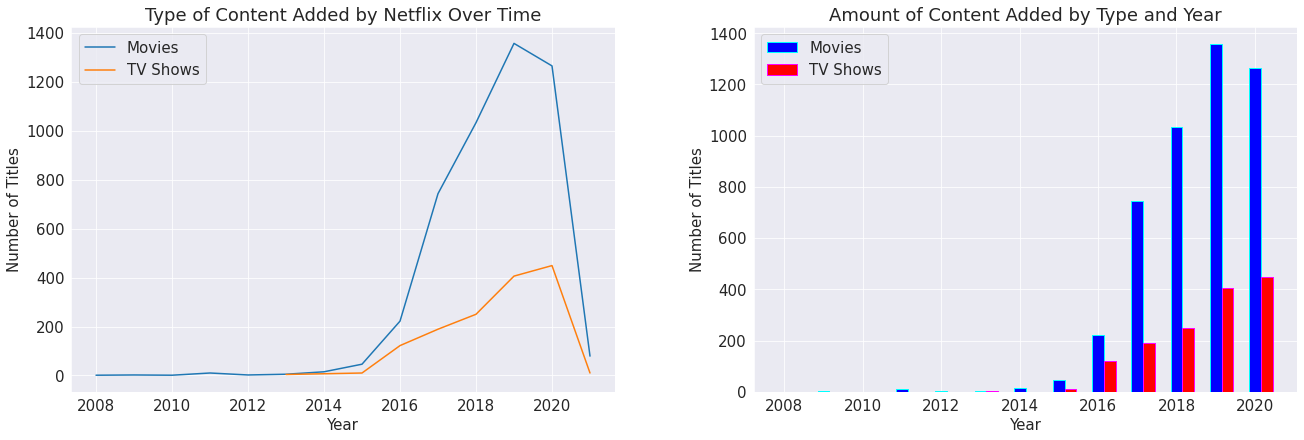

In [31]:
movies_added = df[df.type == 'Movie'].groupby('year_added').title.count()
tv_added = df[df.type == 'TV Show'].groupby('year_added').title.count()

years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
shows = []
movies = []
for year in years:
    shows.append([year, df[(df.type == 'TV Show') & (df.year_added == year)].title.count()])
    movies.append([year, df[(df.type == 'Movie') & (df.year_added == year)].title.count()])
shows = np.array(shows)
movies = np.array(movies)

fig, axes = plt.subplots(1, 2, figsize=(20,8))

sns.lineplot(x=movies_added.index, y=movies_added, ax=axes[0]);
sns.lineplot(x=tv_added.index, y=tv_added, ax=axes[0]);
axes[0].set_title(label='Type of Content Added by Netflix Over Time')
axes[0].set_xlabel("Year");
axes[0].set_ylabel("Number of Titles");
axes[0].legend(labels=['Movies', 'TV Shows']);

blue_bar = movies[:,1]
orange_bar = shows[:,1]

ind = np.arange(2008,2021)

width = 0.3       

# Plotting
axes[1].bar(ind, blue_bar , width, label='Movies', color="blue", edgecolor="cyan");
axes[1].bar(ind + width, orange_bar, width, label='TV Shows', color="red", edgecolor="magenta");

axes[1].set_xlabel("Year")
axes[1].set_ylabel('Number of Titles')
axes[1].set_title('Amount of Content Added by Type and Year')
axes[1].set_xticks(ind + width / 2, minor=years)
axes[1].legend();

plt.tight_layout(pad=5)

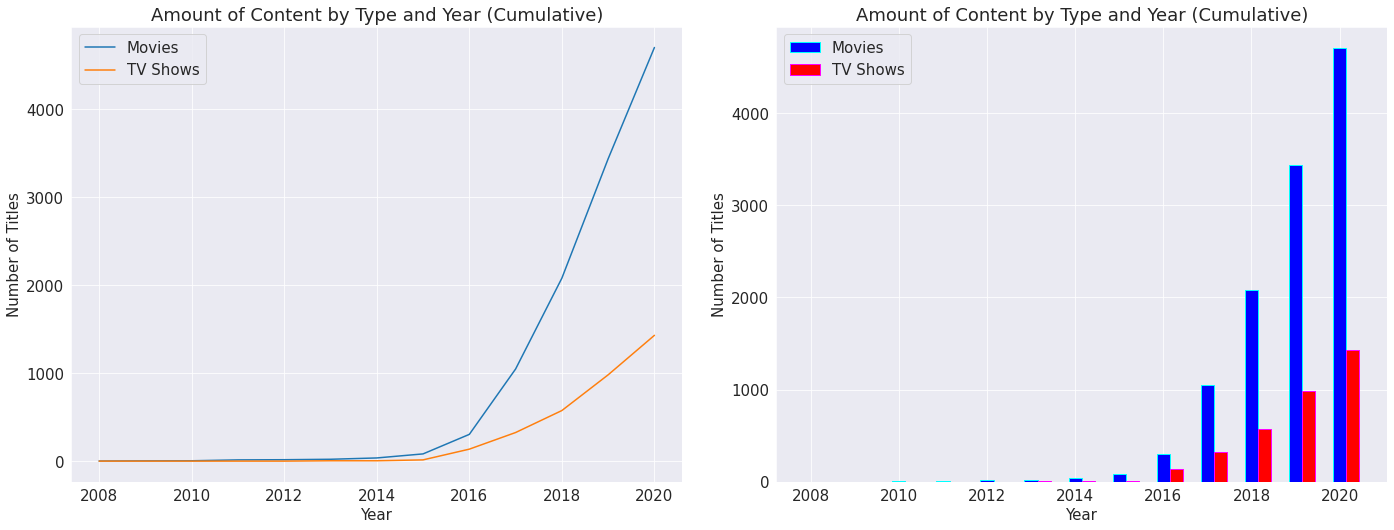

In [33]:
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
shows = []
movies = []
for year in years:
    shows.append([year, df[(df.type == 'TV Show') & (df.year_added <= year)].title.count()])
    movies.append([year, df[(df.type == 'Movie') & (df.year_added <= year)].title.count()])
shows = np.array(shows)
movies = np.array(movies)


# Create axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(20,8));

matplotlib.rcParams["font.size"] = 15

# Set up lineplot on axes[0]
sns.lineplot(x=movies[:,0], y=movies[:,1], ax=axes[0]);
sns.lineplot(x=shows[:,0], y=shows[:,1], ax=axes[0]);
axes[0].set_title(label='Amount of Content by Type and Year (Cumulative)')
axes[0].set_xlabel("Year");
axes[0].set_ylabel("Number of Titles");
axes[0].legend(labels=['Movies', 'TV Shows']);

# Set up bar graph
blue_bar = movies[:,1]
orange_bar = shows[:,1]
ind = np.arange(2008,2021)
width = 0.3       

# Plotting bar graph on axes[1]
axes[1].bar(ind, blue_bar , width, label='Movies', color="Blue", edgecolor="Cyan");
axes[1].bar(ind + width, orange_bar, width, label='TV Shows', color="Red", edgecolor="Magenta");
axes[1].set_xlabel('Year');
axes[1].set_ylabel('Number of Titles');
axes[1].set_title('Amount of Content by Type and Year (Cumulative)');
axes[1].legend(["Movies", "TV Shows"]);

axes[1].set_xticks(ind + width / 2, minor=years);

plt.tight_layout(pad=2);

## How much of each type of content is available?

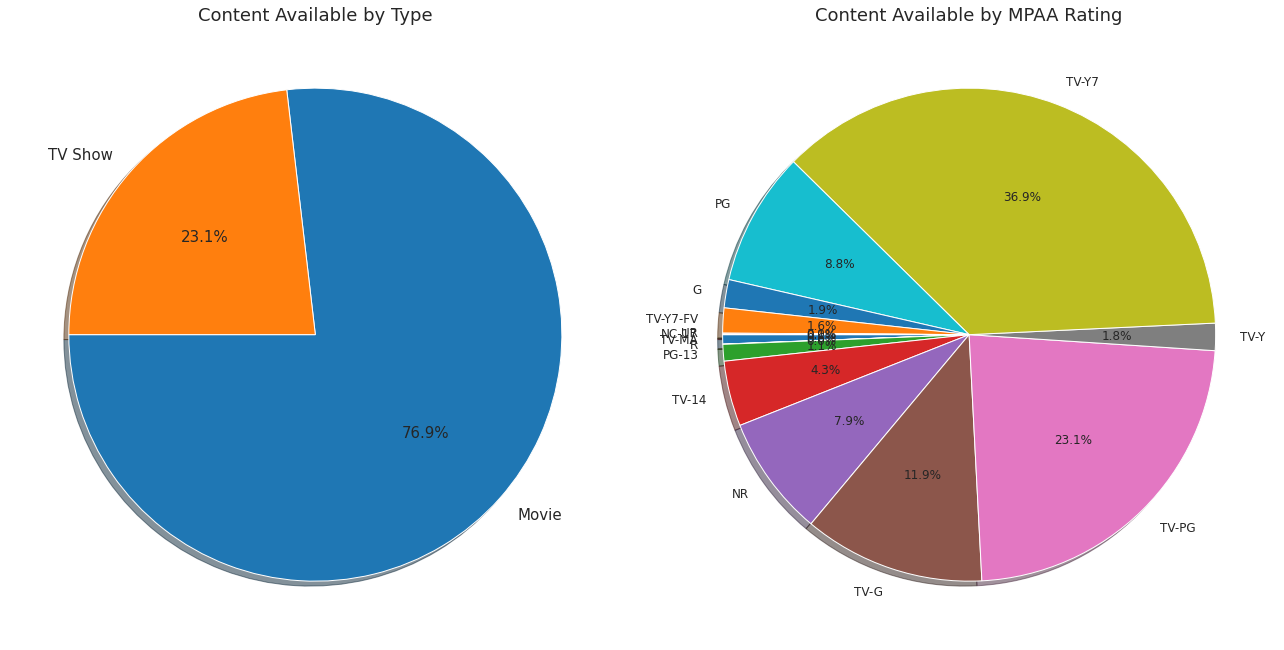

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
matplotlib.rcParams["font.size"] = 15

axes[0].set_title("Content Available by Type")
axes[0].pie(df.groupby("type")["title"].count(), labels=df["type"].unique(), autopct="%1.1f%%", startangle=180, shadow=True);

axes[1].set_title("Content Available by MPAA Rating")
matplotlib.rcParams["font.size"] = 12
axes[1].pie(df[df["rating"] != "Unknown"].groupby("rating")["title"].count(), labels=df[df["rating"] != "Unknown"]["rating"].unique(), autopct="%1.1f%%", startangle=180, shadow=True);

plt.tight_layout()

## How many regions is Netflix available in?

In [36]:
print(f"Netflix is available in {len(df[df.country_count == 1].country.unique())} countries.")

Netflix is available in 62 countries.


## What are the distribution and density of user ratings?

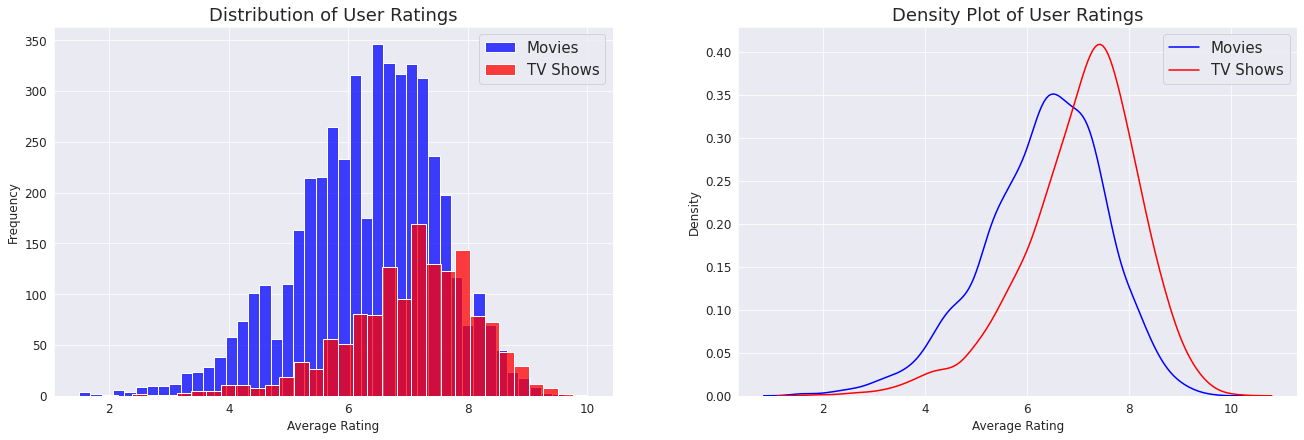

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

fig.fontsize = 15

matplotlib.rcParams["font.size"] = 15

sns.histplot(x=df[df["type"] == "Movie"]["averageRating"], color="Blue", ax=axes[0]);
sns.histplot(x=df[df["type"] == "TV Show"]["averageRating"], color="Red", ax=axes[0]);
axes[0].set_title("Distribution of User Ratings")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Frequency")
axes[0].legend(labels=["Movies", "TV Shows"]);

sns.kdeplot(x=df[df["type"] == "Movie"]["averageRating"], color="Blue", ax=axes[1]);
sns.kdeplot(x=df[df["type"] == 'TV Show']["averageRating"], color="Red", ax=axes[1]);
axes[1].set_title("Density Plot of User Ratings")
axes[1].set_xlabel("Average Rating")
axes[1].set_ylabel("Density")
axes[1].legend(labels=["Movies", "TV Shows"]);

plt.tight_layout(pad=5);

## How do ratings vary by region?

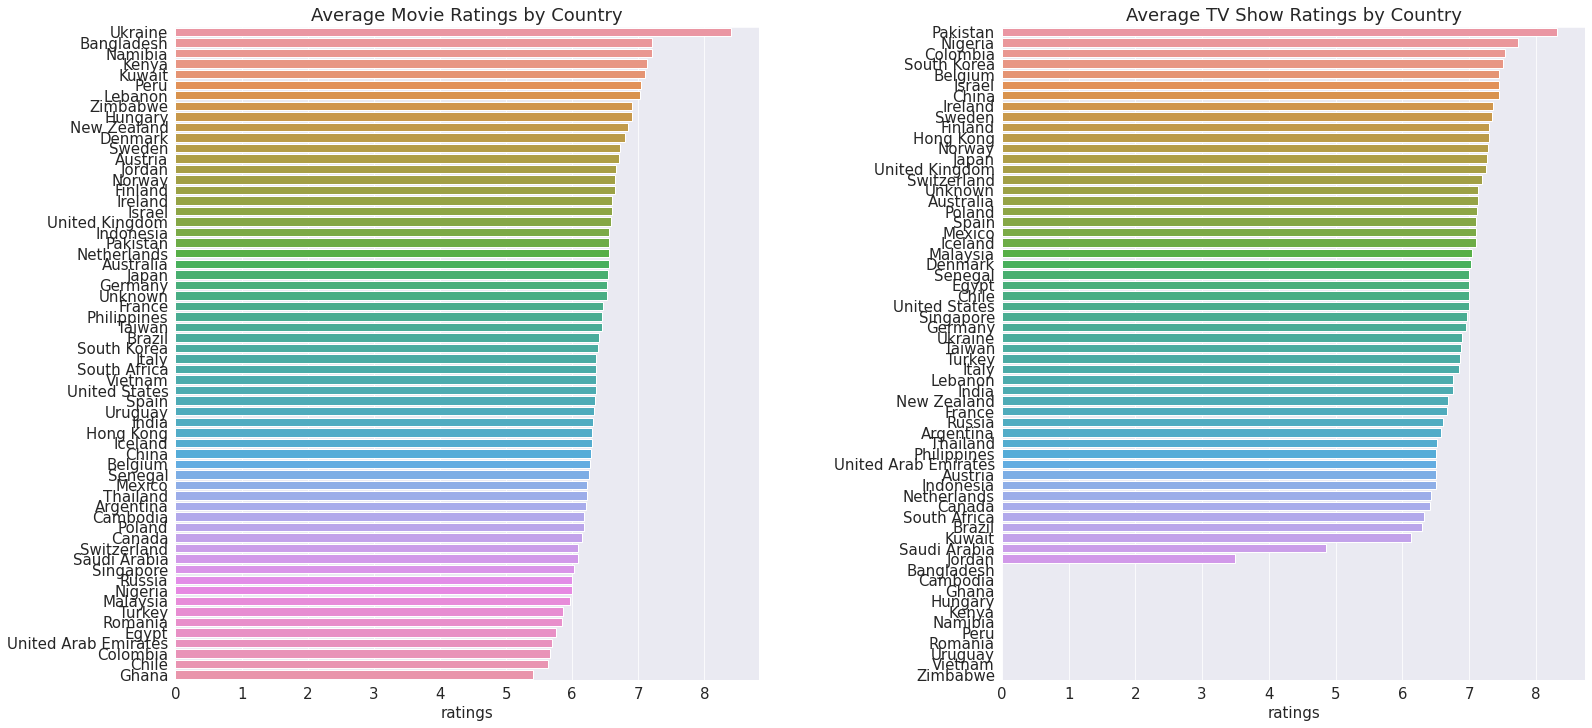

In [42]:
movie_ratings = dict.fromkeys(df[(df.country_count == 1) & (df.country.isna() == False)].country.sort_values().unique())
tv_ratings = dict.fromkeys(df[(df.country_count == 1) & (df.country.isna() == False)].country.sort_values().unique())

for country in movie_ratings.keys():
    movie_ratings[country] = df[(df.country.str.contains(country)) & (df.type == 'Movie')].averageRating.mean()

movie_ratings = pd.DataFrame.from_dict(movie_ratings, orient='index', columns=['ratings'])

for country in tv_ratings.keys():
    tv_ratings[country] = df[(df.country.str.contains(country)) & (df.type == 'TV Show')].averageRating.mean()

tv_ratings = pd.DataFrame.from_dict(tv_ratings, orient='index', columns=['ratings'])

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].set_title('Average Movie Ratings by Country')
sns.barplot(x=movie_ratings.ratings.sort_values(ascending=False), y=movie_ratings.sort_values('ratings', ascending=False).index, ax=axes[0]);

axes[1].set_title('Average TV Show Ratings by Country')
sns.barplot(x=tv_ratings.ratings.sort_values(ascending=False), y=tv_ratings.sort_values('ratings', ascending=False).index, ax=axes[1]);

plt.tight_layout(pad=5)

## How has the prevalence of MPAA ratings and users' opinions of them changed over time?

#### We can use a heatmap to visualize the amount of content uploaded per year for each MPAA rating.

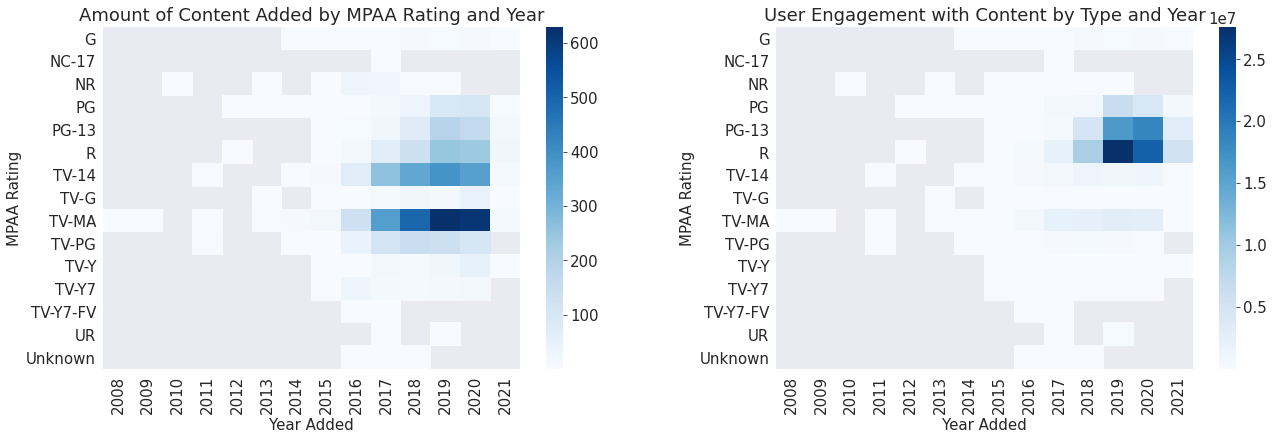

In [49]:
# Create dataframe with necessary data columns
rating_df = df.groupby(["country", "rating", "year_added"]).agg({"averageRating":"mean", "title":"count", "numVotes":"sum"}).reset_index()

# Creating the dataframe for the averageRating heatmap
heatmap_df = rating_df.groupby(["year_added", "rating"])["numVotes"].sum().reset_index()
ratings_pivot = pd.DataFrame(heatmap_df.pivot("rating", "year_added", "numVotes"))

# Creating the dataframe for the title_count heatmap
heatmap_df2 = rating_df.groupby(["year_added", "rating"])["title"].sum().reset_index()
ratings_pivot2 = pd.DataFrame(heatmap_df2.pivot("rating", "year_added", "title"))

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(ratings_pivot2, cmap="Blues", ax=axes[0]);
axes[0].set_title("Amount of Content Added by MPAA Rating and Year")
axes[0].set_xlabel("Year Added")
axes[0].set_ylabel("MPAA Rating")

sns.heatmap(ratings_pivot, cmap="Blues", ax=axes[1]);
axes[1].set_title("User Engagement with Content by Type and Year")
axes[1].set_xlabel("Year Added")
axes[1].set_ylabel("MPAA Rating")

plt.tight_layout(pad=5)

##### A limitation of this method is that there is no record of WHEN a user's rating was entered so tracking users' ratings of different MPAA categories is dependent on either the year the work was released or the year the work was added to netflix, and is also subject to changing user ratings.

#### Who were the most popular directors?

In [38]:
director_df = df[(df["year_added"] >= 2016) & (df['year_added'] <= 2019)].groupby(["country", "rating", "year_added", "director"]).agg({"averageRating":"mean", "title":"count"}).reset_index()
pd.DataFrame(director_df[director_df["director"] != "Unknown"].groupby("director")["title"].sum().sort_values(ascending=False)).head(10)

,title
director,
"Raúl Campos, Jan Suter",14
Marcus Raboy,13
Jay Chapman,10
"Anthony Russo, Joe Russo",10
Steven Spielberg,10
Johnnie To,9
Jay Karas,8
Peyton Reed,8
Ryan Polito,7


##### Future Question: Who were the most popular cast members?

#### In which years were the most highly rated movies released?

In [39]:
test_df2 = df[df["type"] == "Movie"].sort_values(["release_year", "averageRating"], ascending=False)

max_df = pd.DataFrame()

for year in df["release_year"].unique():
  max_df = pd.concat([max_df, test_df2[test_df2["release_year"] == year].sort_values("averageRating", ascending=False).iloc[[0]]])

In [40]:
test_df = df[df["type"] == "Movie"].groupby("release_year")["averageRating"].mean().sort_values(ascending=False).reset_index()
test_df["best_movie"] = test_df["release_year"].map(lambda x: max_df[max_df["release_year"] == x]["title"].item())
test_df["director"] = test_df["release_year"].map(lambda x: max_df[max_df["release_year"] == x]["director"].item())
test_df["best_movie_user_rating"] = test_df["release_year"].map(lambda x: max_df[max_df["release_year"] == x]["averageRating"].item())
test_df["best_movie_country"] = test_df["release_year"].map(lambda x: max_df[max_df["release_year"] == x]["country"].item())
test_df["num_votes"] = test_df["release_year"].map(lambda x: max_df[max_df["release_year"] == x]["numVotes"].item())
test_df["num_movies"] = test_df["release_year"].map(lambda x: df[(df["type"] == "Movie") & (df["release_year"] == x)].groupby("release_year")["title"].count().item())

In [41]:
test_df.head(10)

,release_year,averageRating,best_movie,director,best_movie_user_rating,best_movie_country,num_votes,num_movies
0,1972,8.300000,koshish,Gulzar,8.6,India,1468,2
1,1964,8.000000,sangam,Raj Kapoor,8.5,India,15,2
2,1963,7.800000,saladin,Youssef Chahine,7.8,Egypt,2170,1
3,1968,7.675000,once upon a time in the west,Sergio Leone,8.5,"Italy, United States",302060,4
4,1965,7.650000,doctor zhivago,David Lean,8.0,"United States, Italy, United Kingdom, Liechten...",69728,2
5,1967,7.633333,cool hand luke,Stuart Rosenberg,8.1,United States,161501,3
6,1970,7.600000,the cruise,Marek Piwowski,7.6,Poland,3128,1
7,1954,7.550000,white christmas,Michael Curtiz,7.6,United States,34428,2
8,1958,7.466667,cat on a hot tin roof,Richard Brooks,8.0,United States,44947,3
9,1980,7.337500,whispers,Maroun Baghdadi,8.6,"Lebanon, Canada, France",24,8


## What are the most popular shows from each region?
### Use the Dropdown menu below to select a country.

Dropdown(description='Countries', index=57, options=('Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgi…

Button(description='TV Shows', style=ButtonStyle())

Output()

Button(description='Movies', style=ButtonStyle())

Output()

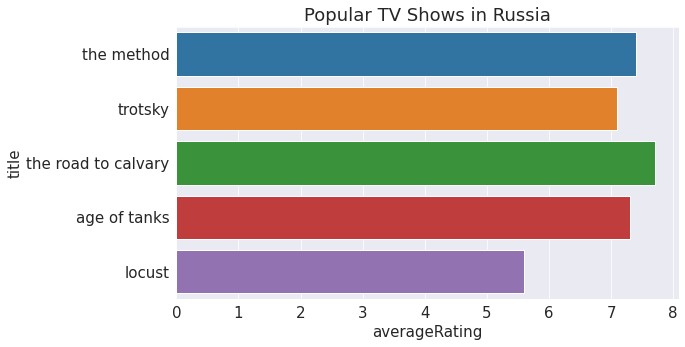

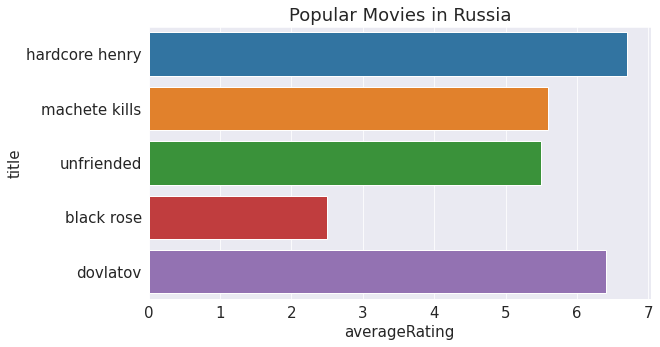

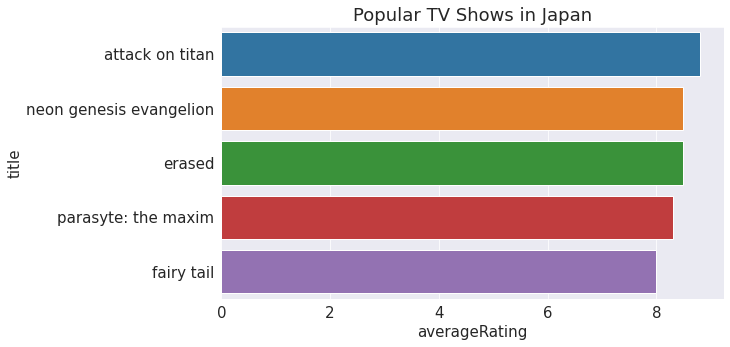

In [42]:
country_list = df[(df.country.isna() == False) & (df.country_count == 1)].country.sort_values().unique().tolist()

country_select = widgets.Dropdown(
                    options = country_list,
                    value = 'United States',
                    description = 'Countries',
                    disabled = False)

display(country_select)

button = widgets.Button(description="TV Shows")
button1 = widgets.Button(description="Movies")
output = widgets.Output()
output1 = widgets.Output()

matplotlib.rcParams["font.size"] = 15

display(button, output)
display(button1, output1)

def on_button_clicked(b):
    tv_df = df[(df.country.str.contains(country_select.value)) & (df.type == 'TV Show')].sort_values('numVotes', ascending=False)
    with output:
        if tv_df.index.size == 0:
          print("Cannot Graph.")
        else:
          plt.title(label='Popular TV Shows in ' + country_select.value)
          sns.barplot(x=tv_df.averageRating.head(5), y=tv_df.title.head(5))
        
def on_button_clicked1(b):
    movie_df = df[(df.country.str.contains(country_select.value)) & (df.type == 'Movie')].sort_values('numVotes', ascending=False)
    with output1:
        if movie_df.index.size == 0:
          print("Cannot Graph.")
        else:
          plt.title(label='Popular Movies in ' + country_select.value)
          sns.barplot(x=movie_df.averageRating.head(5), y=movie_df.title.head(5))

button.on_click(on_button_clicked)
button1.on_click(on_button_clicked1)

## What words are most commonly used in the descriptions?

### We can visualize this with a wordcloud

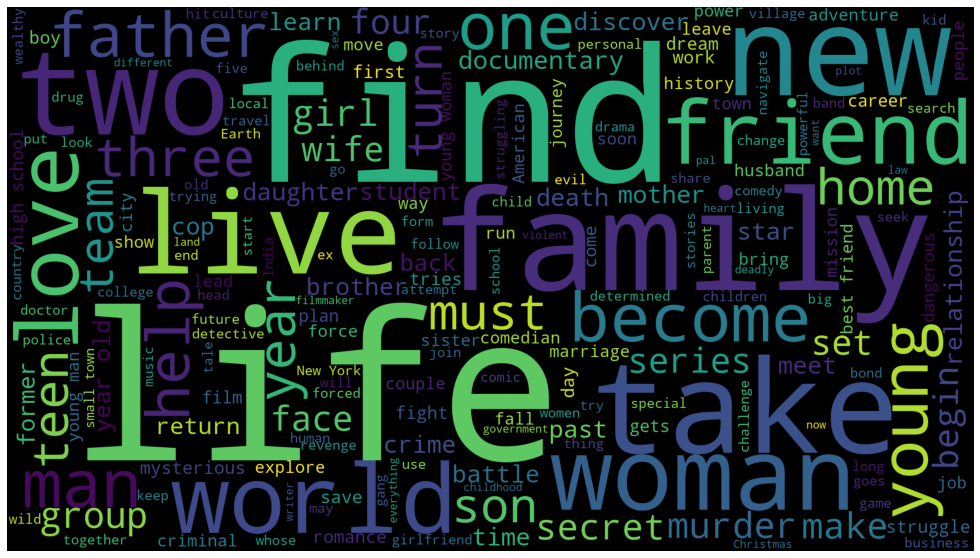

In [43]:
plt.figure(figsize=(20,10))
wordcloud = WordCloud(background_color='Black',
                      width=1920,
                      height=1080
                      ).generate(" ".join(df.description))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('cast.png')
plt.show()

##### "Stopwords" are removed and we are left with a visual representation of the frequency of words in the descriptions.

# Future Work

## Visualize things like most prolific director, actor, etc.

## Use NLP for a recommendation system

## Implement N-grams for actor/director combinations to make predictions on user ratings.

In [44]:
jovian.commit(project='NEW NEW aNetflix and IMDB EDA')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/jandrewtomich/new-new-anetflix-and-imdb-eda


'https://jovian.ai/jandrewtomich/new-new-anetflix-and-imdb-eda'

# Misc